In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [3]:
baseline_vars_df = pd.read_csv('baseline_data.csv')

In [4]:
baseline_df = pd.read_csv('baseline_data.csv')

In [5]:
baseline_df

,year,qtr,state_fips,low,high,FIPS,State,low_diff,YearQuarter,profitability,asset_quality,profitability_diff,assetquality_diff
0,2005,2,1,1.50,1.6,1,alabama,0.00,2005Q2,0.004663,0.004323,0.000935,0.000109
1,2005,3,1,1.40,1.5,1,alabama,-0.10,2005Q3,0.004663,0.004323,0.000935,0.000109
2,2005,4,1,1.40,1.5,1,alabama,0.00,2005Q4,0.004663,0.004323,0.000935,0.000109
3,2006,1,1,1.40,1.5,1,alabama,0.00,2006Q1,0.004514,0.003980,-0.000149,-0.000342
4,2006,2,1,1.40,1.5,1,alabama,0.00,2006Q2,0.004514,0.003980,-0.000149,-0.000342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2007,2,56,1.32,1.4,56,wyoming,0.08,2007Q2,0.008248,0.000955,-0.000785,0.000060
646,2007,3,56,1.32,1.4,56,wyoming,0.00,2007Q3,0.008248,0.000955,-0.000785,0.000060
647,2007,4,56,1.32,1.4,56,wyoming,0.00,2007Q4,0.008248,0.000955,-0.000785,0.000060
648,2008,1,56,1.32,1.4,56,wyoming,0.00,2008Q1,0.006264,0.003617,-0.001984,0.002662


In [24]:
print(baseline_vars_df["high"].values)

[1.11 1.24 1.11 ... 1.4  1.4  1.4 ]


In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [6]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Assume baseline_vars_df is your DataFrame with columns: "State", "asset_quality", "profitability", "high"
selected_vars = ["assetquality_diff", "profitability_diff", "low_diff"]
X = baseline_vars_df[selected_vars].values
states = baseline_vars_df["State"].values

# Standardize the features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Use PCA with whitening to obtain a whitened representation
pca = PCA(whiten=True, random_state=42)
X_whitened = pca.fit_transform(X_scaled)

# Run K-means clustering on the whitened data (this now uses the PCA-based whitening which is robust)
k = 4  # choose appropriate number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_whitened)

# For each state, compute Euclidean distance in the whitened space to its assigned cluster centroid
distances = []
for i in range(len(states)):
    centroid = kmeans.cluster_centers_[clusters[i]]
    d = np.linalg.norm(X_whitened[i] - centroid)
    distances.append(d)

# Use negative distances as the similarity (G) score (higher means more similar to the centroid)
kmeans_mahalanobis_scores = pd.DataFrame({
    "State": states,
    "kmeans_mahalanobis_score": -np.array(distances)
})

print("K-Means (Mahalanobis via PCA Whitening) G-Scores:")
print(kmeans_mahalanobis_scores.sort_values("kmeans_mahalanobis_score", ascending=False).head(10))


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


K-Means (Mahalanobis via PCA Whitening) G-Scores:
         State  kmeans_mahalanobis_score
36     arizona                 -0.000000
35     arizona                 -0.000000
34     arizona                 -0.000000
33     arizona                 -0.000000
534  tennessee                 -0.115308
153      idaho                 -0.115815
150      idaho                 -0.115815
152      idaho                 -0.115815
140     hawaii                 -0.120278
138     hawaii                 -0.120278


In [8]:
# Select the baseline variables for G-selection
selected_vars = ["assetquality_diff", "profitability_diff", "low_diff"]
X = baseline_vars_df[selected_vars].values
states = baseline_vars_df["State"].values

# Standardize the features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Compute the covariance matrix and its inverse square root (whitening transformation)
cov_matrix = np.cov(X_scaled, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_matrix)
inv_sqrt_eigvals = np.diag(1.0 / np.sqrt(eigvals))
D = eigvecs.dot(inv_sqrt_eigvals).dot(eigvecs.T)

# Whiten the data; now Euclidean distance equals Mahalanobis distance
X_whitened = X_scaled.dot(D)

# Run K-means clustering on the whitened data (choose k based on your data; here k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_whitened)

# For each state, compute the Euclidean distance from its whitened feature vector to its cluster centroid
distances = []
for i in range(len(states)):
    centroid = kmeans.cluster_centers_[clusters[i]]
    d = np.linalg.norm(X_whitened[i] - centroid)
    distances.append(d)

# Use the negative distance as the similarity (G) score (higher means more similar)
kmeans_mahalanobis_scores = pd.DataFrame({
    "State": states,
    "G_score": -np.array(distances)
})

print("K-Means (Mahalanobis) G-Scores:")
print(kmeans_mahalanobis_scores.sort_values("G_score", ascending=False).head(10))

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


K-Means (Mahalanobis) G-Scores:
         State       G_score
36     arizona -4.440892e-16
35     arizona -4.440892e-16
34     arizona -4.440892e-16
33     arizona -4.440892e-16
534  tennessee -1.153079e-01
150      idaho -1.158151e-01
152      idaho -1.158151e-01
153      idaho -1.158151e-01
139     hawaii -1.202778e-01
137     hawaii -1.202778e-01


Each state’s G-score represents how similar that state’s economic baseline is to the "typical" state in its group, as determined by clustering in a transformed (whitened) feature space. Because we used the negative of the Euclidean distance, a less-negative (or higher) score means the state is closer to its cluster centroid—that is, it more closely resembles the average pattern within its cluster. Conversely, more negative scores indicate the state deviates further from the group’s center, making it less "typical" relative to its peers.

For example, in your output:
- **Arkansas** shows a score of –0.0466. This relatively higher (less-negative) score suggests that Arkansas’s baseline characteristics (asset quality, profitability, and high) are close to the centroid of its cluster—it is very representative of that group.
- **Wisconsin** has a score around –0.0571, slightly lower (more negative) than Arkansas, implying that it is a bit further from its cluster centroid.
- **Maine** shows a score of –0.0628, which is more negative and indicates that Maine is less typical compared to the centroid of its cluster.

In summary, the grouped scores help you quickly assess which states have baseline features that are more central (and thus more similar to other states within their cluster) and which ones are outliers. This similarity measure (or G-score) can then inform your matching process for synthetic control, by either weighting states or selecting a donor pool composed of states with high (less-negative) G-scores.

Grouped K-Means Mahalanobis G-Scores by State:
             State   G_score
10          hawaii -0.208372
25         montana -0.277483
32  north carolina -0.346078
5         colorado -0.354867
19        maryland -0.361419
46      washington -0.383601
36          oregon -0.385956
48       wisconsin -0.412341
39  south carolina -0.412441
49         wyoming -0.413023


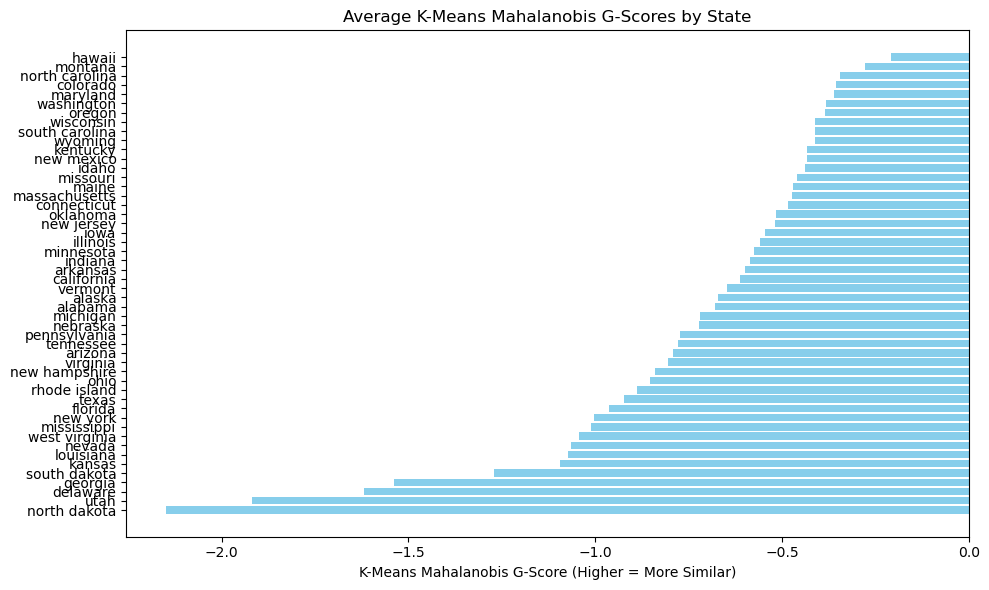

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the scores by State (averaging if there are duplicates)
grouped_scores = kmeans_mahalanobis_scores.groupby("State")["G_score"].mean().reset_index()

# Sort by score descending, so that the highest (i.e., least negative) scores are at the top.
grouped_scores.sort_values("G_score", ascending=False, inplace=True)

print("Grouped K-Means Mahalanobis G-Scores by State:")
print(grouped_scores.head(10))

# Create a horizontal bar plot to visualize the scores
plt.figure(figsize=(10, 6))
plt.barh(grouped_scores["State"], grouped_scores["G_score"], color='skyblue')
plt.xlabel("K-Means Mahalanobis G-Score (Higher = More Similar)")
plt.title("Average K-Means Mahalanobis G-Scores by State")
plt.gca().invert_yaxis()  # So that the state with the highest score appears at the top
plt.tight_layout()
plt.show()


Negative Distance as a Similarity Score

You see negative values because you used –(Euclidean distance). A value closer to zero (e.g., –0.2) indicates a smaller original distance to the cluster centroid, meaning that state is more representative (or “typical”) of its cluster.

Large negative values (like –2.5) mean that state is relatively far from the centroid, making it less typical within its group.

Plot Interpretation

States at the top of the chart (with more negative bars) have lower G-scores, meaning they deviate more from their cluster’s average. They’re effectively “outliers” or “less similar” to the cluster.

States at the bottom (bars near zero) are the most similar to their cluster centroid and thus are “typical” examples within that cluster’s baseline features.

Why This Matters

If you’re using these G-scores to pick a donor pool or do baseline grouping, states with higher (less-negative) G-scores are more “central” and can be considered good representatives of that cluster’s patterns.

Conversely, states with very negative G-scores might be outliers to treat separately or investigate further for unique economic structures.

Practical Takeaways

Connecticut, Massachusetts, Wisconsin, and Kentucky (among others at the top) are relatively far from their cluster centroids, so they might be outliers in terms of your baseline variables (asset_quality, profitability, high).

States lower on the chart (closer to zero) are more typical or standard within their clusters. If you’re selecting controls for a synthetic control analysis, these states might end up being more likely to match well with treated states in the same cluster.

In short, the bar chart visually shows each state’s “distance from average” within its cluster. Higher bars (less negative) = more representative states; lower bars (very negative) = more atypical states in the context of the baseline features you used.

In [10]:
kmeans_mahalanobis_scores.to_csv('kmeans_mahalanobis_robust_scores.csv', index=False)

In [11]:
gdp_df = pd.read_csv('gdp_growth_data.csv')

gdp_df

,GeoFips,LineCode,Description,Time,GDP,State,YearQuarter,gdp_growth
0,1000,1,All industry total,2005:Q1,195673.0,alabama,2005 Q1,NaN
1,1000,1,All industry total,2005:Q2,197495.8,alabama,2005 Q2,0.009316
2,1000,1,All industry total,2005:Q3,196798.5,alabama,2005 Q3,-0.003531
3,1000,1,All industry total,2005:Q4,199018.6,alabama,2005 Q4,0.011281
4,1000,1,All industry total,2006:Q1,199142.9,alabama,2006 Q1,0.000625
...,...,...,...,...,...,...,...,...
2365,55000,1,All industry total,2023:Q3,346067.0,wisconsin,2023 Q3,0.013137
2366,55000,1,All industry total,2023:Q4,350266.1,wisconsin,2023 Q4,0.012134
2367,55000,1,All industry total,2024:Q1,349300.9,wisconsin,2024 Q1,-0.002756
2368,55000,1,All industry total,2024:Q2,352941.1,wisconsin,2024 Q2,0.010421


In [13]:
# ------------------------------------------------------------------
# 0)  Standardise YearQuarter in baseline_df  →  PeriodIndex
# ------------------------------------------------------------------
baseline_df["YearQuarter"] = (
    baseline_df["YearQuarter"]
      .astype(str)
      .str.replace(" Q", "Q", regex=False)      # "2005 Q2" → "2005Q2"
)
baseline_df["YearQuarter"] = pd.PeriodIndex(baseline_df["YearQuarter"], freq="Q")



In [14]:
base_start = pd.Period("2005Q2", freq="Q")
base_end   = pd.Period("2008Q2", freq="Q")

baseline_trim = baseline_df.loc[
    (baseline_df["YearQuarter"] >= base_start) &
    (baseline_df["YearQuarter"] <= base_end)
].copy()

baseline_trim

,year,qtr,state_fips,low,high,FIPS,State,low_diff,YearQuarter,profitability,asset_quality,profitability_diff,assetquality_diff
0,2005,2,1,1.50,1.6,1,alabama,0.00,2005Q2,0.004663,0.004323,0.000935,0.000109
1,2005,3,1,1.40,1.5,1,alabama,-0.10,2005Q3,0.004663,0.004323,0.000935,0.000109
2,2005,4,1,1.40,1.5,1,alabama,0.00,2005Q4,0.004663,0.004323,0.000935,0.000109
3,2006,1,1,1.40,1.5,1,alabama,0.00,2006Q1,0.004514,0.003980,-0.000149,-0.000342
4,2006,2,1,1.40,1.5,1,alabama,0.00,2006Q2,0.004514,0.003980,-0.000149,-0.000342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2007,2,56,1.32,1.4,56,wyoming,0.08,2007Q2,0.008248,0.000955,-0.000785,0.000060
646,2007,3,56,1.32,1.4,56,wyoming,0.00,2007Q3,0.008248,0.000955,-0.000785,0.000060
647,2007,4,56,1.32,1.4,56,wyoming,0.00,2007Q4,0.008248,0.000955,-0.000785,0.000060
648,2008,1,56,1.32,1.4,56,wyoming,0.00,2008Q1,0.006264,0.003617,-0.001984,0.002662


In [18]:
# --------------------------------------------------------------
# Keep every quarter (1999Q1–2008Q2) without averaging anything
# --------------------------------------------------------------
baseline_long = baseline_trim.loc[
    :, ["State", "YearQuarter", "assetquality_diff", "profitability_diff", "low_diff"]
].copy()

# If you want a separate column that labels the first quarter in the window
# (purely for reference), add it but KEEP all rows:
first_q = (
    baseline_long
        .sort_values("YearQuarter")
        .groupby("State")["YearQuarter"]
        .first()
        .reset_index()
        
)

baseline_long = baseline_long.merge(first_q, on="State", how="left")

print(baseline_long.head())


     State YearQuarter_x  assetquality_diff  profitability_diff  low_diff  \
0  alabama        2005Q2           0.000109            0.000935       0.0   
1  alabama        2005Q3           0.000109            0.000935      -0.1   
2  alabama        2005Q4           0.000109            0.000935       0.0   
3  alabama        2006Q1          -0.000342           -0.000149       0.0   
4  alabama        2006Q2          -0.000342           -0.000149       0.0   

  YearQuarter_y  
0        2005Q2  
1        2005Q2  
2        2005Q2  
3        2005Q2  
4        2005Q2  


In [19]:
baseline_long.drop(columns=["YearQuarter_y"], inplace=True, axis=1)
baseline_long.rename(columns={"YearQuarter_x": "YearQuarter"}, inplace=True)

In [20]:
baseline_long

,State,YearQuarter,assetquality_diff,profitability_diff,low_diff
0,alabama,2005Q2,0.000109,0.000935,0.00
1,alabama,2005Q3,0.000109,0.000935,-0.10
2,alabama,2005Q4,0.000109,0.000935,0.00
3,alabama,2006Q1,-0.000342,-0.000149,0.00
4,alabama,2006Q2,-0.000342,-0.000149,0.00
...,...,...,...,...,...
645,wyoming,2007Q2,0.000060,-0.000785,0.08
646,wyoming,2007Q3,0.000060,-0.000785,0.00
647,wyoming,2007Q4,0.000060,-0.000785,0.00
648,wyoming,2008Q1,0.002662,-0.001984,0.00


In [16]:
gdp_df = pd.read_csv("gdp_growth_data.csv")
gdp_df["State"] = gdp_df["State"].str.lower().str.strip()

# normalise YearQuarter string and convert to PeriodIndex
gdp_df["YearQuarter"] = (
    gdp_df["YearQuarter"].astype(str).str.replace(" Q", "Q", regex=False)
)
gdp_df["YearQuarter"] = pd.PeriodIndex(gdp_df["YearQuarter"], freq="Q")

pret_start = pd.Period("2005Q2", freq="Q")
pret_end   = pd.Period("2008Q2", freq="Q")

gdp_pre_long = (
    gdp_df.loc[
        (gdp_df["YearQuarter"] >= pret_start) &
        (gdp_df["YearQuarter"] <= pret_end)
    ][["State", "YearQuarter", "gdp_growth"]]
      .rename(columns={"gdp_growth": "GDP_pre"})
)

In [17]:
gdp_pre_long

,State,YearQuarter,GDP_pre
1,alabama,2005Q2,0.009316
2,alabama,2005Q3,-0.003531
3,alabama,2005Q4,0.011281
4,alabama,2006Q1,0.000625
5,alabama,2006Q2,0.004461
...,...,...,...
2300,wisconsin,2007Q2,0.002859
2301,wisconsin,2007Q3,0.004935
2302,wisconsin,2007Q4,-0.000746
2303,wisconsin,2008Q1,-0.006978


In [21]:
merged_panel = baseline_long.merge(
    gdp_pre_long,
    on=["State", "YearQuarter"],
    how="inner"
)

print(merged_panel.head())
print("Rows:", len(merged_panel))

     State YearQuarter  assetquality_diff  profitability_diff  low_diff  \
0  alabama      2005Q2           0.000109            0.000935       0.0   
1  alabama      2005Q3           0.000109            0.000935      -0.1   
2  alabama      2005Q4           0.000109            0.000935       0.0   
3  alabama      2006Q1          -0.000342           -0.000149       0.0   
4  alabama      2006Q2          -0.000342           -0.000149       0.0   

    GDP_pre  
0  0.009316  
1 -0.003531  
2  0.011281  
3  0.000625  
4  0.004461  
Rows: 390


In [22]:
merged_panel.to_csv("merged_panel.csv", index=False)

In [1]:
import pandas as pd

merged_panel = pd.read_csv("merged_panel.csv")

In [3]:
from arch.unitroot import PhillipsPerron
import numpy as np

# Group the DataFrame by state
states = merged_panel['State'].unique()

# Create a list to store states that fail the test
non_stationary_states = []

# Define the significance level
alpha = 0.05

# Perform the PP test for each state
for state in states:
    # Get the asset_quality data for the state, sorted by time
    state_data = merged_panel[merged_panel['State'] == state].sort_values('YearQuarter')['asset_quality']
    
    # Skip if there's not enough variation in the data
    if np.std(state_data) < 1e-10:
        print(f"{state}: Skipped (no variation in data)")
        continue
    
    # Run the Phillips-Perron test
    try:
        pp = PhillipsPerron(state_data)
        result = pp.pvalue
        
        # Check if the state fails the stationarity test
        # If p-value > alpha, we can't reject the null hypothesis of a unit root (non-stationary)
        if result > alpha:
            non_stationary_states.append((state, result))
    except:
        print(f"{state}: Error running PP test")

# Display the states that fail the PP test
print(f"\nStates failing the Phillips-Perron test (p-value > {alpha}):")
for state, p_value in sorted(non_stationary_states, key=lambda x: x[1], reverse=True):
    print(f"{state}: p-value = {p_value:.4f}")


States failing the Phillips-Perron test (p-value > 0.05):
pennsylvania: p-value = 0.9941
california: p-value = 0.9939
utah: p-value = 0.9936
michigan: p-value = 0.9931
texas: p-value = 0.9925
colorado: p-value = 0.9923
ohio: p-value = 0.9920
illinois: p-value = 0.9899
maine: p-value = 0.9889
missouri: p-value = 0.9868
florida: p-value = 0.9865
wisconsin: p-value = 0.9858
virginia: p-value = 0.9839
washington: p-value = 0.9762
maryland: p-value = 0.9758
georgia: p-value = 0.9747
indiana: p-value = 0.9732
nebraska: p-value = 0.9708
alaska: p-value = 0.9703
kansas: p-value = 0.9685
idaho: p-value = 0.9658
connecticut: p-value = 0.9653
iowa: p-value = 0.9530
alabama: p-value = 0.9528
oregon: p-value = 0.9447
tennessee: p-value = 0.9234
oklahoma: p-value = 0.8653
kentucky: p-value = 0.7298
montana: p-value = 0.5074
louisiana: p-value = 0.4518


In [4]:
# Group the DataFrame by state
states = merged_panel['State'].unique()

# Create a list to store states that fail the test
non_stationary_states = []

# Define the significance level
alpha = 0.05

# Perform the PP test for each state
for state in states:
    # Get the asset_quality data for the state, sorted by time
    state_data = merged_panel[merged_panel['State'] == state].sort_values('YearQuarter')['profitability']
    
    # Skip if there's not enough variation in the data
    if np.std(state_data) < 1e-10:
        print(f"{state}: Skipped (no variation in data)")
        continue
    
    # Run the Phillips-Perron test
    try:
        pp = PhillipsPerron(state_data)
        result = pp.pvalue
        
        # Check if the state fails the stationarity test
        # If p-value > alpha, we can't reject the null hypothesis of a unit root (non-stationary)
        if result > alpha:
            non_stationary_states.append((state, result))
    except:
        print(f"{state}: Error running PP test")

# Display the states that fail the PP test
print(f"\nStates failing the Phillips-Perron test (p-value > {alpha}):")
for state, p_value in sorted(non_stationary_states, key=lambda x: x[1], reverse=True):
    print(f"{state}: p-value = {p_value:.4f}")


States failing the Phillips-Perron test (p-value > 0.05):
texas: p-value = 0.9968
tennessee: p-value = 0.9966
connecticut: p-value = 0.9963
illinois: p-value = 0.9961
ohio: p-value = 0.9960
maryland: p-value = 0.9956
michigan: p-value = 0.9947
montana: p-value = 0.9945
oregon: p-value = 0.9941
wisconsin: p-value = 0.9938
pennsylvania: p-value = 0.9929
missouri: p-value = 0.9913
florida: p-value = 0.9905
idaho: p-value = 0.9903
nebraska: p-value = 0.9855
alabama: p-value = 0.9729
alaska: p-value = 0.9589
iowa: p-value = 0.9529
california: p-value = 0.9372
washington: p-value = 0.9340
maine: p-value = 0.9262
georgia: p-value = 0.8304
virginia: p-value = 0.8081
utah: p-value = 0.7901
indiana: p-value = 0.7652
colorado: p-value = 0.7182
kansas: p-value = 0.5886
oklahoma: p-value = 0.5460
kentucky: p-value = 0.5251
louisiana: p-value = 0.4575


In [5]:
# Group the DataFrame by state
states = merged_panel['State'].unique()

# Create a list to store states that fail the test
non_stationary_states = []

# Define the significance level
alpha = 0.05

# Perform the PP test for each state
for state in states:
    # Get the asset_quality data for the state, sorted by time
    state_data = merged_panel[merged_panel['State'] == state].sort_values('YearQuarter')['low']
    
    # Skip if there's not enough variation in the data
    if np.std(state_data) < 1e-10:
        print(f"{state}: Skipped (no variation in data)")
        continue
    
    # Run the Phillips-Perron test
    try:
        pp = PhillipsPerron(state_data)
        result = pp.pvalue
        
        # Check if the state fails the stationarity test
        # If p-value > alpha, we can't reject the null hypothesis of a unit root (non-stationary)
        if result > alpha:
            non_stationary_states.append((state, result))
    except:
        print(f"{state}: Error running PP test")

# Display the states that fail the PP test
print(f"\nStates failing the Phillips-Perron test (p-value > {alpha}):")
for state, p_value in sorted(non_stationary_states, key=lambda x: x[1], reverse=True):
    print(f"{state}: p-value = {p_value:.4f}")

california: Skipped (no variation in data)
colorado: Skipped (no variation in data)
georgia: Error running PP test
maryland: Skipped (no variation in data)
washington: Skipped (no variation in data)

States failing the Phillips-Perron test (p-value > 0.05):
utah: p-value = 0.9490
idaho: p-value = 0.9192
alabama: p-value = 0.8010
montana: p-value = 0.6771
oregon: p-value = 0.6771
virginia: p-value = 0.6771
maine: p-value = 0.6122
alaska: p-value = 0.6040
illinois: p-value = 0.4672
missouri: p-value = 0.4672
indiana: p-value = 0.4608
pennsylvania: p-value = 0.4492
connecticut: p-value = 0.4274
michigan: p-value = 0.4274
nebraska: p-value = 0.1304
kentucky: p-value = 0.1254
louisiana: p-value = 0.1197
iowa: p-value = 0.1102


In [32]:
merged_panel.to_csv("merged_panel.csv",index=False)

In [30]:
merged_panel = baseline_long.merge(
    gdp_pre_long,
    on=["State", "YearQuarter"],
    how="inner"
)

print(merged_panel.head())
print("Rows:", len(merged_panel))

     State YearQuarter  asset_quality  profitability  low   GDP_pre
0  alabama      2005Q2       0.004323       0.004663  1.5  0.009316
1  alabama      2005Q3       0.004323       0.004663  1.4 -0.003531
2  alabama      2005Q4       0.004323       0.004663  1.4  0.011281
3  alabama      2006Q1       0.003980       0.004514  1.4  0.000625
4  alabama      2006Q2       0.003980       0.004514  1.4  0.004461
Rows: 390


In [ ]:
merged_panel.to_csv('merged_panel.csv', index=False)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
merged_panel = pd.read_csv('merged_panel.csv')

## Adaptive Lasso

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
from sklearn.linear_model import LassoCV

In [35]:
merged_panel = pd.read_csv('merged_panel.csv')

In [24]:
vars_X = ["assetquality_diff", "profitability_diff", "low_diff"]
panel = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X = panel[vars_X].values
y = panel["GDP_pre"].values
states = panel["State"].values

### Standard Scaler

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#   2)  Initial OLS to get raw betas
# ------------------------------------------------------------------
beta_ols = np.linalg.lstsq(X_scaled, y, rcond=None)[0]

# Adaptive weight w_j = 1 / |beta_ols_j|^γ   (γ = 1)
gamma = 1.0
weights = 1.0 / (np.abs(beta_ols) ** gamma + 1e-8)

In [27]:
#   3)  Rescale columns of X by 1/weights  ➔  X_rescaled
# ------------------------------------------------------------------
X_rescaled = X_scaled / weights[np.newaxis, :]

# ------------------------------------------------------------------
#   4)  LassoCV on rescaled design
# ------------------------------------------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_rescaled, y)
beta_adaptive = lasso.coef_ / weights          # back‑transform coefficients

print("Adaptive‑Lasso coefficients:")
for v, b in zip(vars_X, beta_adaptive):
    print(f"  {v}: {b: .4f}")

# ------------------------------------------------------------------
#   5)  G‑score for each observation:   X_scaled · β_adaptive
# ------------------------------------------------------------------
panel["G_score_adaptive"] = X_scaled.dot(beta_adaptive)

Adaptive‑Lasso coefficients:
  assetquality_diff: -0.0011
  profitability_diff:  0.0000
  low_diff: -0.0020


In [28]:
adaptive_state_score = (
    panel.groupby("State")["G_score_adaptive"]
         .mean()
         .reset_index()
         .sort_values("G_score_adaptive", ascending=False)
)

In [29]:
# ---------------------------
# adaptive_state_score already exists
# columns:  State | G_score_adaptive
# ---------------------------
ranked_states = (
    adaptive_state_score
      .sort_values("G_score_adaptive", ascending=False)   # highest first
      .reset_index(drop=True)
      .rename(columns={"G_score_adaptive": "G_score"})
)

# Display the top 10 (or any slice you need)
print(ranked_states.head(10))


         State   G_score
0    louisiana  0.001014
1     kentucky  0.000710
2       kansas  0.000615
3     oklahoma  0.000613
4     colorado  0.000552
5     maryland  0.000450
6      indiana  0.000438
7         ohio  0.000370
8  connecticut  0.000354
9      montana  0.000352


In [30]:
ranked_states = (
    adaptive_state_score
      .sort_values("G_score_adaptive", ascending=False)
      .reset_index(drop=True)
      .rename(columns={"G_score_adaptive": "G_score"})
)


         State   G_score
0    louisiana  0.001014
1     kentucky  0.000710
2       kansas  0.000615
3     oklahoma  0.000613
4     colorado  0.000552
5     maryland  0.000450
6      indiana  0.000438
7         ohio  0.000370
8  connecticut  0.000354
9      montana  0.000352
         State   G_score
20    illinois -0.000152
21   wisconsin -0.000252
22     georgia -0.000262
23       idaho -0.000281
24      alaska -0.000321
25    michigan -0.000434
26  california -0.000570
27    virginia -0.000646
28     florida -0.001193
29        utah -0.002188


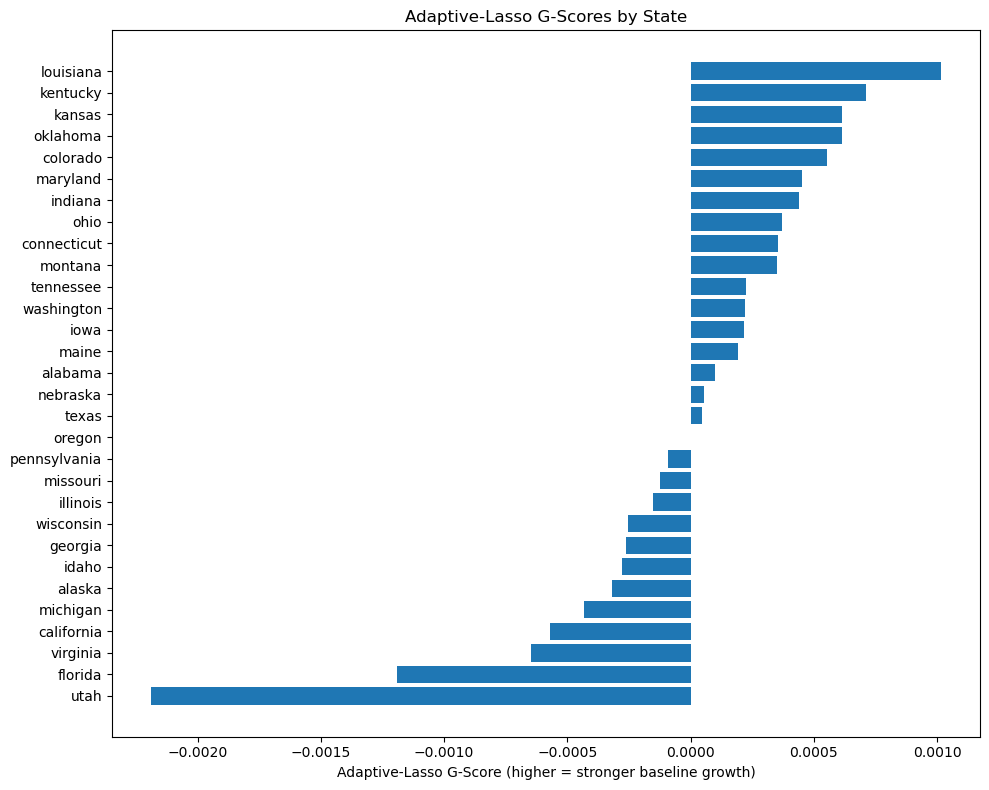

In [31]:
import matplotlib.pyplot as plt

# 0)  ensure `ranked_states` exists
print(ranked_states.head(10))          # top 10
print(ranked_states.tail(10))          # bottom 10

# 1)  horizontal bar chart of all states
plt.figure(figsize=(10, 8))
plt.barh(ranked_states["State"], ranked_states["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("Adaptive‑Lasso G‑Score (higher = stronger baseline growth)")
plt.title("Adaptive‑Lasso G‑Scores by State")
plt.tight_layout()
plt.show()



In [32]:
import numpy as np

# ------------------------------------------------------------
# y  and  X_scaled  were defined earlier
# beta_adaptive is the coefficient vector we estimated
# ------------------------------------------------------------
y_hat = X_scaled.dot(beta_adaptive)

# ----------  R‑squared --------------------------------------
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2      = 1.0 - ss_res / ss_tot

# ----------  AIC / BIC  (Gaussian likelihood) ---------------
n  = len(y)                 # number of observations
k  = len(beta_adaptive)     # number of estimated parameters
sigma2 = ss_res / n         # ML estimate of error variance

# log‑likelihood for Gaussian errors with constant variance
logL = -0.5 * n * (np.log(2*np.pi*sigma2) + 1)

AIC = -2 * logL + 2 * k
BIC = -2 * logL + k * np.log(n)

print(f"Adaptive‑Lasso in‑sample metrics")
print(f"  R²   : {r2: .4f}")
print(f"  AIC  : {AIC: .1f}")
print(f"  BIC  : {BIC: .1f}")


Adaptive‑Lasso in‑sample metrics
  R²   : -0.1429
  AIC  : -2265.7
  BIC  : -2253.8


In [33]:
# n = observations, k = number of predictors
n = len(y)
k = X_scaled.shape[1]

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print(f"Adjusted R² : {adj_r2: .4f}")


Adjusted R² : -0.1518


In [34]:
#   3)  Rescale columns of X by 1/weights  ➔  X_rescaled
# ------------------------------------------------------------------
X_rescaled = X_scaled / weights[np.newaxis, :]

# ------------------------------------------------------------------
#   4)  LassoCV on rescaled design
# ------------------------------------------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_rescaled, y)
beta_adaptive = lasso.coef_ / weights          # back‑transform coefficients

print("Adaptive‑Lasso coefficients:")
for v, b in zip(vars_X, beta_adaptive):
    print(f"  {v}: {b: .4f}")

# ------------------------------------------------------------------
#   5)  G‑score for each observation:   X_scaled · β_adaptive
# ------------------------------------------------------------------
panel["G_score_adaptive"] = X_scaled.dot(beta_adaptive)

Adaptive‑Lasso coefficients:
  assetquality_diff: -0.0011
  profitability_diff:  0.0000
  low_diff: -0.0020


### Robust Scaler

In [35]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

#   2)  Initial OLS to get raw betas
# ------------------------------------------------------------------
beta_ols = np.linalg.lstsq(X_scaled, y, rcond=None)[0]

# Adaptive weight w_j = 1 / |beta_ols_j|^γ   (γ = 1)
gamma = 1.0
weights = 1.0 / (np.abs(beta_ols) ** gamma + 1e-8)

In [36]:
adaptive_state_score = (
    panel.groupby("State")["G_score_adaptive"]
         .mean()
         .reset_index()
         .sort_values("G_score_adaptive", ascending=False)
)

In [37]:
# ---------------------------
# adaptive_state_score already exists
# columns:  State | G_score_adaptive
# ---------------------------
ranked_states = (
    adaptive_state_score
      .sort_values("G_score_adaptive", ascending=False)   # highest first
      .reset_index(drop=True)
      .rename(columns={"G_score_adaptive": "G_score"})
)

# Display the top 10 (or any slice you need)
print(ranked_states.head(10))


         State   G_score
0    louisiana  0.001014
1     kentucky  0.000710
2       kansas  0.000615
3     oklahoma  0.000613
4     colorado  0.000552
5     maryland  0.000450
6      indiana  0.000438
7         ohio  0.000370
8  connecticut  0.000354
9      montana  0.000352


In [38]:
ranked_states = (
    adaptive_state_score
      .sort_values("G_score_adaptive", ascending=False)
      .reset_index(drop=True)
      .rename(columns={"G_score_adaptive": "G_score"})
)

         State   G_score
0    louisiana  0.001014
1     kentucky  0.000710
2       kansas  0.000615
3     oklahoma  0.000613
4     colorado  0.000552
5     maryland  0.000450
6      indiana  0.000438
7         ohio  0.000370
8  connecticut  0.000354
9      montana  0.000352
         State   G_score
20    illinois -0.000152
21   wisconsin -0.000252
22     georgia -0.000262
23       idaho -0.000281
24      alaska -0.000321
25    michigan -0.000434
26  california -0.000570
27    virginia -0.000646
28     florida -0.001193
29        utah -0.002188


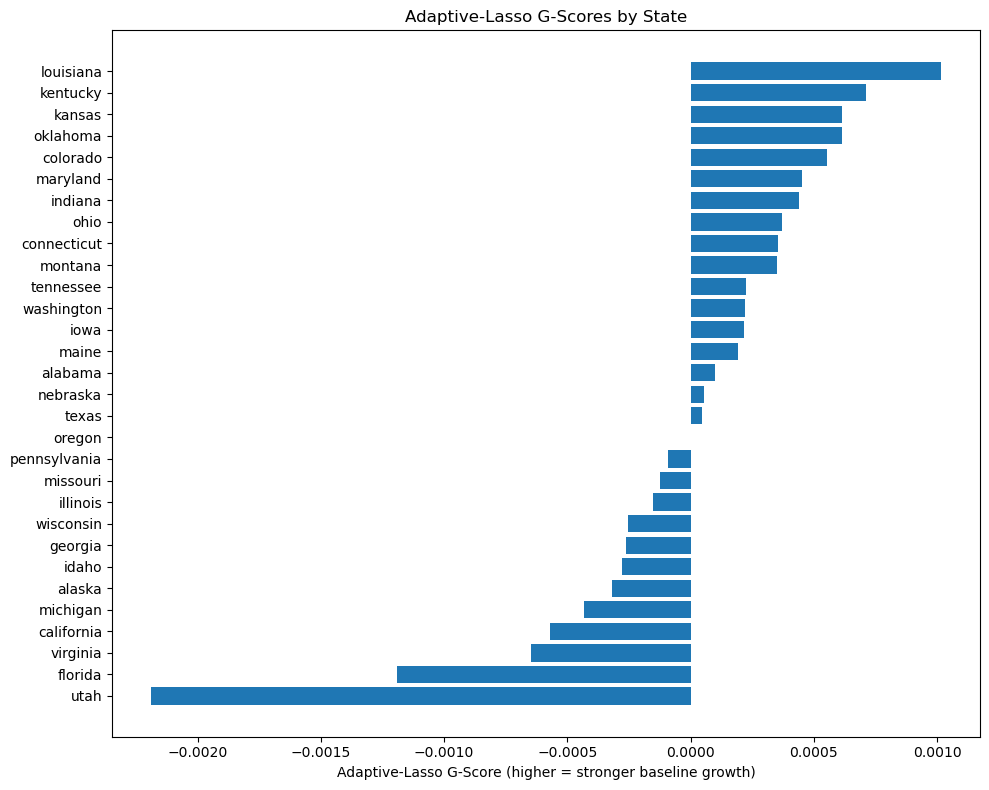

In [39]:
import matplotlib.pyplot as plt

# 0)  ensure `ranked_states` exists
print(ranked_states.head(10))          # top 10
print(ranked_states.tail(10))          # bottom 10

# 1)  horizontal bar chart of all states
plt.figure(figsize=(10, 8))
plt.barh(ranked_states["State"], ranked_states["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("Adaptive‑Lasso G‑Score (higher = stronger baseline growth)")
plt.title("Adaptive‑Lasso G‑Scores by State")
plt.tight_layout()
plt.show()


In [40]:
# ------------------------------------------------------------
# y  and  X_scaled  were defined earlier
# beta_adaptive is the coefficient vector we estimated
# ------------------------------------------------------------
y_hat = X_scaled.dot(beta_adaptive)

# ----------  R‑squared --------------------------------------
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2      = 1.0 - ss_res / ss_tot

# ----------  AIC / BIC  (Gaussian likelihood) ---------------
n  = len(y)                 # number of observations
k  = len(beta_adaptive)     # number of estimated parameters
sigma2 = ss_res / n         # ML estimate of error variance

# log‑likelihood for Gaussian errors with constant variance
logL = -0.5 * n * (np.log(2*np.pi*sigma2) + 1)

AIC = -2 * logL + 2 * k
BIC = -2 * logL + k * np.log(n)

print(f"Adaptive‑Lasso in‑sample metrics")
print(f"  R²   : {r2: .4f}")
print(f"  AIC  : {AIC: .1f}")
print(f"  BIC  : {BIC: .1f}")

Adaptive‑Lasso in‑sample metrics
  R²   : -0.2284
  AIC  : -2237.5
  BIC  : -2225.6


In [42]:
# n = observations, k = number of predictors
n = len(y)
k = X_scaled.shape[1]

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print(f"Adjusted R² : {adj_r2: .4f}")


Adjusted R² : -0.2379


In [43]:
#   3)  Rescale columns of X by 1/weights  ➔  X_rescaled
# ------------------------------------------------------------------
X_rescaled = X_scaled / weights[np.newaxis, :]

# ------------------------------------------------------------------
#   4)  LassoCV on rescaled design
# ------------------------------------------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_rescaled, y)
beta_adaptive = lasso.coef_ / weights          # back‑transform coefficients

print("Adaptive‑Lasso coefficients:")
for v, b in zip(vars_X, beta_adaptive):
    print(f"  {v}: {b: .4f}")

# ------------------------------------------------------------------
#   5)  G‑score for each observation:   X_scaled · β_adaptive
# ------------------------------------------------------------------
panel["G_score_adaptive"] = X_scaled.dot(beta_adaptive)

Adaptive‑Lasso coefficients:
  assetquality_diff: -0.0002
  profitability_diff:  0.0000
  low_diff: -0.0241


## Decision Tree

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [45]:
vars_X = ["assetquality_diff", "profitability_diff", "low_diff"]

panel = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()
X_raw = panel[vars_X].values
y      = panel["GDP_pre"].values
states = panel["State"].values            # for later aggregation

# (Trees do not require scaling, but scaling keeps workflows symmetric)
scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

In [46]:
# 2)  Hyper‑parameter tuning (max_depth via CV)
# ---------------------------------------------------------------
param_grid = {"max_depth": [2, 3, 4, 5, 6, 10, None],
              "min_samples_leaf": [1, 2, 4]}

tree = DecisionTreeRegressor(random_state=42)
cv    = KFold(n_splits=5, shuffle=True, random_state=42)

grid  = GridSearchCV(tree, param_grid,
                     cv=cv,
                     scoring="neg_mean_squared_error")
grid.fit(X, y)

best_tree = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")

# ---------------------------------------------------------------
# 3)  In‑sample fit metrics
# ---------------------------------------------------------------
y_hat = best_tree.predict(X)
r2  = r2_score(y, y_hat)
mse = mean_squared_error(y, y_hat)
print(f"Decision‑Tree R²  : {r2: .4f}")
print(f"Decision‑Tree MSE : {mse: .5f}")

# ---------------------------------------------------------------
# 4)  Compute G‑score for each observation
# ---------------------------------------------------------------
panel["G_score_tree"] = y_hat

# ---------------------------------------------------------------
# 5)  Aggregate to one score per state  (mean across quarters)
# ---------------------------------------------------------------
tree_state_score = (
    panel.groupby("State")["G_score_tree"]
         .mean()
         .reset_index()
         .sort_values("G_score_tree", ascending=False)
         .reset_index(drop=True)
)

print("\nDecision‑Tree G‑scores (top 10 states):")
print(tree_state_score.head(10))

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1}
Decision‑Tree R²  :  0.4113
Decision‑Tree MSE :  0.00009

Decision‑Tree G‑scores (top 10 states):
         State  G_score_tree
0     oklahoma      0.009714
1        texas      0.008836
2       kansas      0.008253
3   washington      0.008145
4  connecticut      0.008005
5         iowa      0.007841
6         utah      0.007698
7     colorado      0.007239
8     virginia      0.007118
9     nebraska      0.006454


Top 10 states (Decision‑Tree G‑score):
         State  G_score_tree
0     oklahoma      0.009714
1        texas      0.008836
2       kansas      0.008253
3   washington      0.008145
4  connecticut      0.008005
5         iowa      0.007841
6         utah      0.007698
7     colorado      0.007239
8     virginia      0.007118
9     nebraska      0.006454 

Bottom 10 states:
        State  G_score_tree
20      maine      0.004064
21    montana      0.003887
22  wisconsin      0.003738
23     alaska      0.003368
24   missouri      0.002926
25    florida      0.002734
26   michigan      0.002694
27   illinois      0.002298
28    georgia      0.001252
29  louisiana     -0.001770


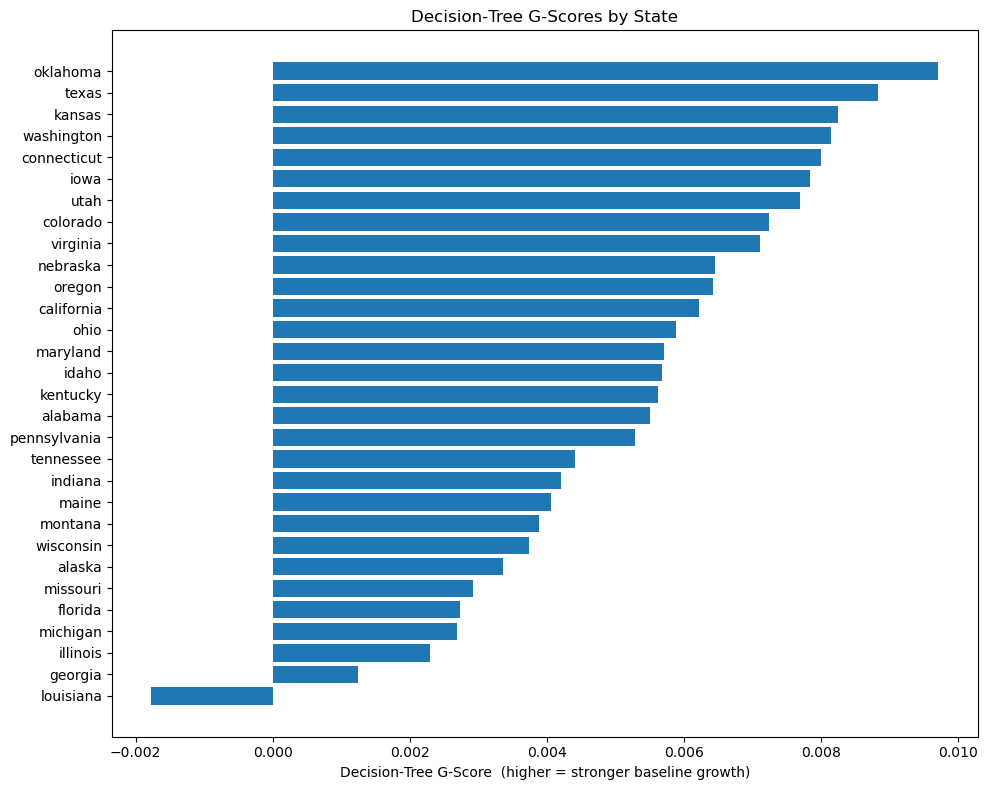

In [47]:
print("Top 10 states (Decision‑Tree G‑score):")
print(tree_state_score.head(10), "\n")

print("Bottom 10 states:")
print(tree_state_score.tail(10))

# ------------------------------------------------------------------
# 2)  Horizontal bar chart of ALL states
# ------------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.barh(tree_state_score["State"], tree_state_score["G_score_tree"])
plt.gca().invert_yaxis()
plt.xlabel("Decision‑Tree G‑Score  (higher = stronger baseline growth)")
plt.title("Decision‑Tree G‑Scores by State")
plt.tight_layout()
plt.show()

In [50]:
from sklearn.model_selection import cross_val_score

# 1) Adjusted R²
n = len(y)
p = len(vars_X)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {r2_adj:.4f}")

# 2) AIC & BIC (assume k = number of leaves as model complexity)
rss = np.sum((y - y_hat) ** 2)
k   = best_tree.get_n_leaves()
aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + np.log(n) * k
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

# 3) 5‑fold CV R²
cv_r2 = cross_val_score(best_tree, X, y, cv=cv, scoring="r2")
print(f"5‑fold CV R²: {cv_r2.mean():.4f} (± {cv_r2.std():.4f})")


Adjusted R²: 0.4067
AIC: -3589.18
BIC: -3493.99
5‑fold CV R²: -0.1210 (± 0.0943)


In [51]:
tree_state_score.to_csv('decision_tree_scores.csv',index=False)

## RF Proximity

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [53]:
vars_X = ["assetquality_diff", "profitability_diff", "low_diff"]

# merged_panel built earlier: YearQuarter‑by‑State observations
panel = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_raw = panel[vars_X].values
y      = panel["GDP_pre"].values
states = panel["State"].values

# RFs don’t need scaling, but keep same workflow
scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

In [54]:
# 2)   Fit Random Forest
# ---------------------------------------------------------------
rf = RandomForestRegressor(
        n_estimators = 92,
        max_depth    = None,
        min_samples_leaf = 1,
        oob_score    = True,
        random_state = 42,
        n_jobs       = -1
     )

rf.fit(X, y)
print(f"OOB‑R² : {rf.oob_score_: .4f}")

OOB‑R² : -0.1776


In [55]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
import numpy as np

# 1) In‑sample predictions
y_hat = rf.predict(X)

# 2) Sample size and number of predictors
n = len(y)
p = X.shape[1]

# --- Adjusted R² ---
r2 = r2_score(y, y_hat)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {r2_adj:.4f}")

# --- AIC & BIC (use total leaves across all trees as 'k') ---
rss = np.sum((y - y_hat) ** 2)
k   = sum(est.tree_.n_leaves for est in rf.estimators_)
aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + np.log(n) * k
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

# --- 5‑fold CV R² ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(rf, X, y, cv=cv, scoring="r2")
print(f"5‑fold CV R²: {cv_r2.mean():.4f} (± {cv_r2.std():.4f})")


Adjusted R²: 0.5837
AIC: 24876.71
BIC: 81695.73
5‑fold CV R²: -0.2336 (± 0.1675)


In [56]:
# 3)   Proximity matrix  P_{ij}
#      P_{ij} = (1/T) Σ_t  1{ leaf_t(i) == leaf_t(j) }
# ---------------------------------------------------------------
# Leaf indices for every tree  →  shape (n_samples, n_trees)
leaf_index = rf.apply(X)          # dtype = int32

n_samples, n_trees = leaf_index.shape
P = np.zeros((n_samples, n_samples), dtype=np.float32)

#   For each tree, add 1 where observations share the same leaf.
for t in range(n_trees):
    leaves = leaf_index[:, t]
    # group by leaf id
    _, inv = np.unique(leaves, return_inverse=True)
    # build an indicator matrix via broadcasting
    # P += 1 where leaf ids match
    P += (inv[:, None] == inv[None, :])


P /= n_trees       # convert counts → share of trees   (0‒1)

In [57]:
# 4)   Observation‑level proximity score
obs_score = (P.sum(axis=1) - 1) / (n_samples - 1)   # exclude diagonal

panel["G_score_rfprox"] = obs_score

# ---------------------------------------------------------------
# 5)   Aggregate to STATE‑level score
# ---------------------------------------------------------------
rf_state_score = (
    panel.groupby("State")["G_score_rfprox"]
         .mean()                       # mean over quarters
         .reset_index()
         .sort_values("G_score_rfprox", ascending=False)
         .rename(columns={"G_score_rfprox": "G_score"})
         .reset_index(drop=True)
)

print("\nRandom‑Forest Proximity G‑scores (top 10):")
print(rf_state_score.head(10))


Random‑Forest Proximity G‑scores (top 10):
        State   G_score
0    colorado  0.007375
1  washington  0.007351
2    maryland  0.007304
3  california  0.006839
4     georgia  0.006702
5     florida  0.006586
6        ohio  0.006440
7     montana  0.006364
8       idaho  0.006287
9        utah  0.006231


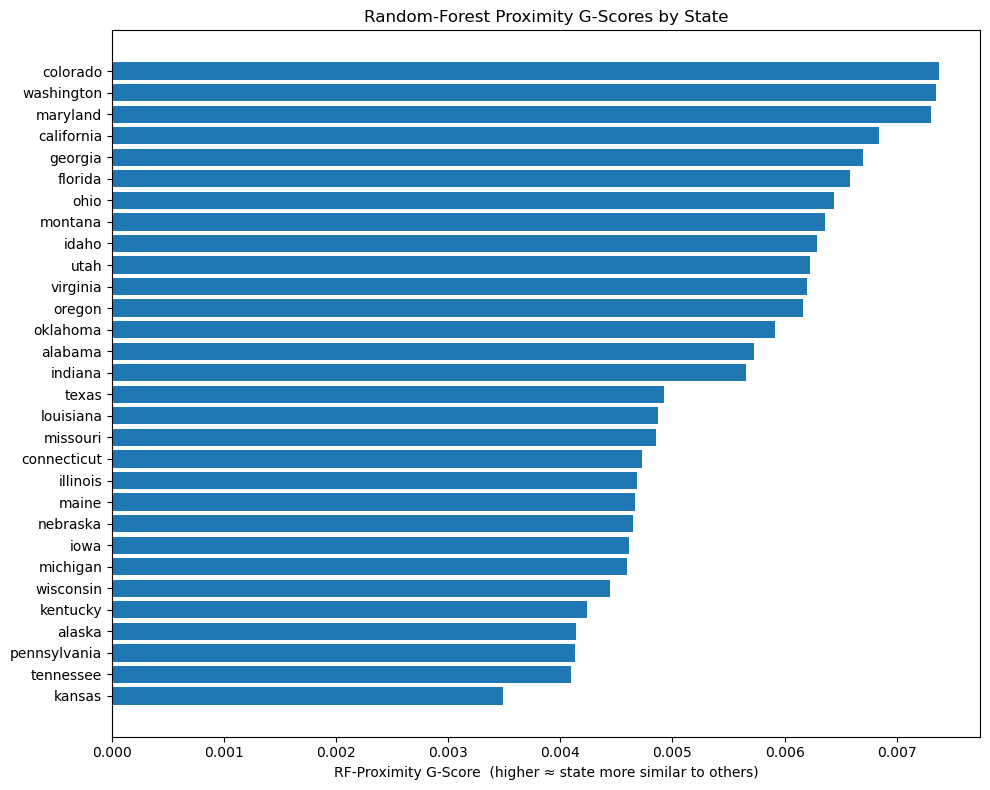

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.barh(rf_state_score["State"], rf_state_score["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("RF‑Proximity G‑Score  (higher ≈ state more similar to others)")
plt.title("Random‑Forest Proximity G‑Scores by State")
plt.tight_layout()
plt.show()

In [59]:
rf_state_score.to_csv('rf_proximity_scores.csv',index=False)

## XG Boost

In [60]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [61]:
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)


In [62]:
from sklearn.pipeline import Pipeline

In [63]:
vars_X = ["assetquality_diff", "profitability_diff", "low_diff"]   # predictors
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X = panel[vars_X].values
y = panel["GDP_pre"].values
states = panel["State"].values


In [76]:
pipe = Pipeline([
    ("scaler", RobustScaler()),        # optional for XGB, required for other models
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    "n_estimators":   [200, 400],
    "learning_rate":  [0.01, 0.1],
    "max_depth":      [3, 4, 5],
    "subsample":      [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5]
}

xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
     )

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
        xgb, param_grid,
        cv=cv,
        scoring="neg_mean_squared_error",
        verbose=0
     ).fit(X, y)

best_xgb = grid.best_estimator_
print("Best XGBoost params:", grid.best_params_)

Best XGBoost params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


In [77]:
y_hat = best_xgb.predict(X)
ins_r2  = r2_score(y, y_hat)
ins_rmse = np.sqrt(mean_squared_error(y, y_hat))

cv_r2 = cross_val_score(best_xgb, X, y, cv=cv, scoring="r2")
print(f"In‑sample  R²  : {ins_r2: .4f}  |  RMSE : {ins_rmse: .5f}")
print(f"5‑fold CV R²  : {cv_r2.mean(): .4f}  (±{cv_r2.std(): .4f})")

In‑sample  R²  :  0.3364  |  RMSE :  0.01002
5‑fold CV R²  :  0.0177  (± 0.0267)


In [78]:
panel["G_score_xgb"] = y_hat

# ---------------------------------------------------------------
# 5)  Aggregate to state‑level score
# ---------------------------------------------------------------
xgb_state_score = (
    panel.groupby("State")["G_score_xgb"]
         .mean()                       # mean across quarters
         .reset_index()
         .sort_values("G_score_xgb", ascending=False)
         .rename(columns={"G_score_xgb": "G_score"})
         .reset_index(drop=True)
)

print("\nXGBoost G‑scores  (top 10 states)")
print(xgb_state_score.head(10))


XGBoost G‑scores  (top 10 states)
         State   G_score
0       kansas  0.008677
1   washington  0.008037
2        texas  0.007974
3  connecticut  0.007590
4         utah  0.007404
5       oregon  0.006960
6     oklahoma  0.006881
7     nebraska  0.006356
8     colorado  0.006013
9        idaho  0.005907


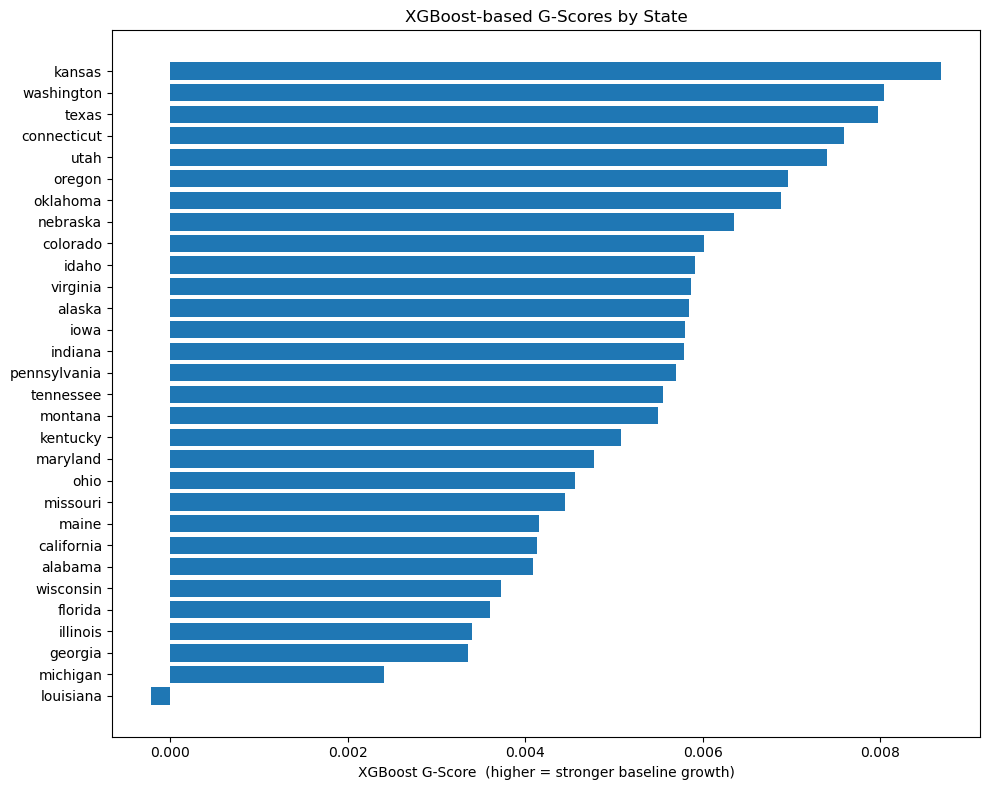

In [79]:
plt.figure(figsize=(10,8))
plt.barh(xgb_state_score["State"], xgb_state_score["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("XGBoost G‑Score  (higher = stronger baseline growth)")
plt.title("XGBoost‑based G‑Scores by State")
plt.tight_layout()
plt.show()

In [80]:
xgb_state_score.to_csv('xgboost_scores.csv',index = False)

## Gaussian Process Regression

In [81]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ConstantKernel as C

In [93]:
# ---------------------------------------------------------------
vars_X = ["assetquality_diff", "profitability_diff", "low_diff"]
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_raw = panel[vars_X].values
y      = panel["GDP_pre"].values
states = panel["State"].values

# Standardise predictors (GPR sensitive to scale)
scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

# ---------------------------------------------------------------
# 2)  Kernel & GP model
# ---------------------------------------------------------------
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(X.shape[1]),
                                      length_scale_bounds=(1e-2, 1e2),
                                      nu=1.5) \
         + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-8,1e-1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20,random_state=42)
gpr.fit(X, y)

'''gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=10,
                               random_state=42)

gpr.fit(X, y)'''

print("\nLearned kernel:", gpr.kernel_)


Learned kernel: 0.0316**2 * Matern(length_scale=[71.4, 100, 0.47], nu=1.5) + WhiteKernel(noise_level=0.000142)


d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [94]:
y_hat   = gpr.predict(X)
ins_r2  = r2_score(y, y_hat)
ins_rmse = np.sqrt(mean_squared_error(y, y_hat))

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(gpr, X, y, cv=cv, scoring="r2")

print("\n=== GPR goodness‑of‑fit ===")
print(f"In‑sample  R²  : {ins_r2: .4f}  |  RMSE : {ins_rmse: .5f}")
print(f"5‑fold CV R²   : {cv_r2.mean(): .4f}  (±{cv_r2.std(): .4f})")

# ---------------------------------------------------------------
# 4)  Observation‑level G‑score   (posterior mean)
# ---------------------------------------------------------------
panel["G_score_gpr"] = y_hat

d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value foun


=== GPR goodness‑of‑fit ===
In‑sample  R²  :  0.0774  |  RMSE :  0.01181
5‑fold CV R²   : -0.0020  (± 0.0821)


d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



GPR  G‑scores  (top 10 states)
         State   G_score
0       kansas  0.007311
1     kentucky  0.006176
2    tennessee  0.006045
3      indiana  0.005775
4        texas  0.005761
5     oklahoma  0.005755
6     colorado  0.005725
7     nebraska  0.005724
8  connecticut  0.005681
9        maine  0.005629


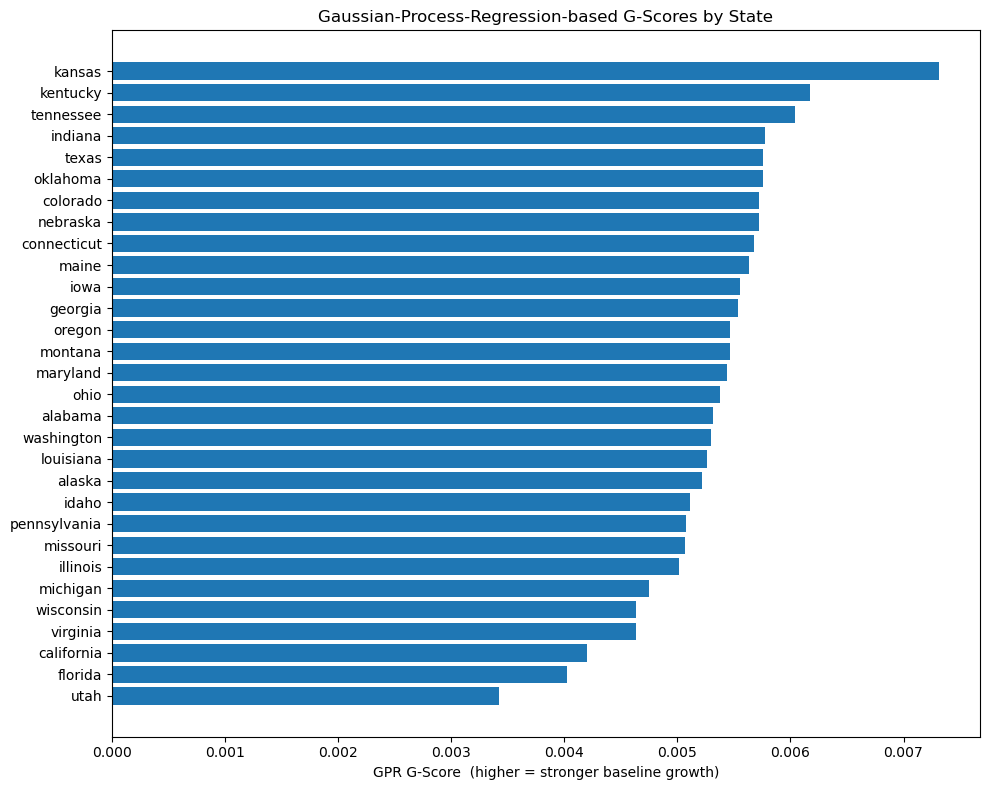

In [95]:
gpr_state_score = (
    panel.groupby("State")["G_score_gpr"]
         .mean()
         .reset_index()
         .sort_values("G_score_gpr", ascending=False)
         .rename(columns={"G_score_gpr": "G_score"})
         .reset_index(drop=True)
)

print("\nGPR  G‑scores  (top 10 states)")
print(gpr_state_score.head(10))

# ---------------------------------------------------------------
# 6)  Visualise
# ---------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.barh(gpr_state_score["State"], gpr_state_score["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("GPR G‑Score  (higher = stronger baseline growth)")
plt.title("Gaussian‑Process‑Regression‑based G‑Scores by State")
plt.tight_layout()
plt.show()

In [96]:
gpr_state_score.to_csv('gpr_state_scores.csv',index = False)

## Penalised Low Dimensional Projection

In [97]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [98]:
vars_X = ["assetquality_diff", "profitability_diff", "low_diff"]
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_raw = panel[vars_X].to_numpy(float)
y      = panel["GDP_pre"].to_numpy(float)
states = panel["State"].values

# Standardise predictors (always before PCA)
Xs = RobustScaler().fit_transform(X_raw)

In [99]:
pca = PCA(n_components=0.95, svd_solver="full")   # here K≤3 anyway
Z   = pca.fit_transform(Xs)                       # low‑dim repr.

print("Explained variance by retained PCs:", pca.explained_variance_ratio_)

Explained variance by retained PCs: [0.84624851 0.15330247]


In [100]:
alphas = np.logspace(-4, 3, 50)
ridge  = RidgeCV(alphas=alphas, cv=5).fit(Z, y)
print("Chosen ridge α:", ridge.alpha_)

#             β in PC‑space  →  β in original‑X space
beta_pc   = ridge.coef_                   # shape (K,)
beta_orig = pca.components_.T @ beta_pc   # shape (p,)


Chosen ridge α: 1000.0


In [101]:
y_hat   = ridge.predict(Z)
r2_in   = r2_score(y, y_hat)
rmse_in = np.sqrt(mean_squared_error(y, y_hat))
cv_r2   = cross_val_score(ridge, Z, y, cv=KFold(5, shuffle=True, random_state=42),
                          scoring="r2")

print(f"In‑sample R² : {r2_in: .4f} | RMSE : {rmse_in: .5f}")
print(f"5‑fold CV R² : {cv_r2.mean(): .4f}  (±{cv_r2.std(): .4f})")

In‑sample R² :  0.0123 | RMSE :  0.01222
5‑fold CV R² : -0.0028  (± 0.0243)


In [102]:
G_scores = Xs @ beta_orig                # uses original X scale

panel["G_score_pldp"] = G_scores

# Aggregate to state
pldp_state = (
    panel.groupby("State")["G_score_pldp"]
         .mean()
         .reset_index()
         .sort_values("G_score_pldp", ascending=False)
         .rename(columns={"G_score_pldp": "G_score"})
         .reset_index(drop=True)
)

print("\nPLDP G‑scores  (top 10 states):")
print(pldp_state.head(10))


PLDP G‑scores  (top 10 states):
         State   G_score
0       kansas  0.000205
1    louisiana  0.000181
2     kentucky  0.000111
3  connecticut  0.000093
4      georgia  0.000073
5      montana  0.000072
6     colorado  0.000054
7       oregon  0.000042
8        maine -0.000050
9      indiana -0.000085


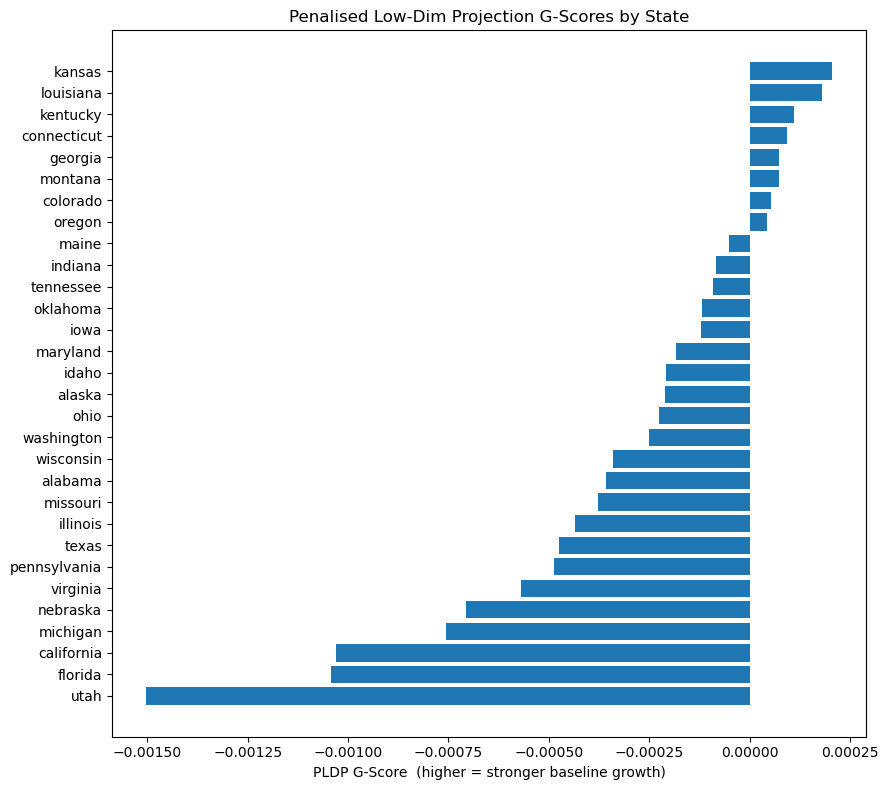

In [103]:
plt.figure(figsize=(9,8))
plt.barh(pldp_state["State"], pldp_state["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("PLDP G‑Score  (higher = stronger baseline growth)")
plt.title("Penalised Low‑Dim Projection G‑Scores by State")
plt.tight_layout()
plt.show()

In [105]:
vars_X = ["assetquality_diff", "profitability_diff", "low_diff"]
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_raw = panel[vars_X].to_numpy(float)
y      = panel["GDP_pre"].to_numpy(float)
states = panel["State"].values

# Standardise predictors (always before PCA)
Xs = StandardScaler().fit_transform(X_raw)

In [106]:
pca = PCA(n_components=0.95, svd_solver="full")   # here K≤3 anyway
Z   = pca.fit_transform(Xs)                       # low‑dim repr.

print("Explained variance by retained PCs:", pca.explained_variance_ratio_)

Explained variance by retained PCs: [0.56026543 0.33335893 0.10637564]


In [107]:
alphas = np.logspace(-4, 3, 50)
ridge  = RidgeCV(alphas=alphas, cv=5).fit(Z, y)
print("Chosen ridge α:", ridge.alpha_)

#             β in PC‑space  →  β in original‑X space
beta_pc   = ridge.coef_                   # shape (K,)
beta_orig = pca.components_.T @ beta_pc   # shape (p,)


Chosen ridge α: 372.7593720314938


In [108]:
y_hat   = ridge.predict(Z)
r2_in   = r2_score(y, y_hat)
rmse_in = np.sqrt(mean_squared_error(y, y_hat))
cv_r2   = cross_val_score(ridge, Z, y, cv=KFold(5, shuffle=True, random_state=42),
                          scoring="r2")

print(f"In‑sample R² : {r2_in: .4f} | RMSE : {rmse_in: .5f}")
print(f"5‑fold CV R² : {cv_r2.mean(): .4f}  (±{cv_r2.std(): .4f})")

In‑sample R² :  0.0358 | RMSE :  0.01208
5‑fold CV R² :  0.0160  (± 0.0177)


In [109]:
G_scores = Xs @ beta_orig                # uses original X scale

panel["G_score_pldp"] = G_scores

# Aggregate to state
pldp_state = (
    panel.groupby("State")["G_score_pldp"]
         .mean()
         .reset_index()
         .sort_values("G_score_pldp", ascending=False)
         .rename(columns={"G_score_pldp": "G_score"})
         .reset_index(drop=True)
)

print("\nPLDP G‑scores  (top 10 states):")
print(pldp_state.head(10))


PLDP G‑scores  (top 10 states):
         State   G_score
0    louisiana  0.000694
1       kansas  0.000638
2     kentucky  0.000501
3     colorado  0.000474
4  connecticut  0.000338
5      indiana  0.000337
6      montana  0.000268
7     oklahoma  0.000253
8     maryland  0.000217
9   washington  0.000194


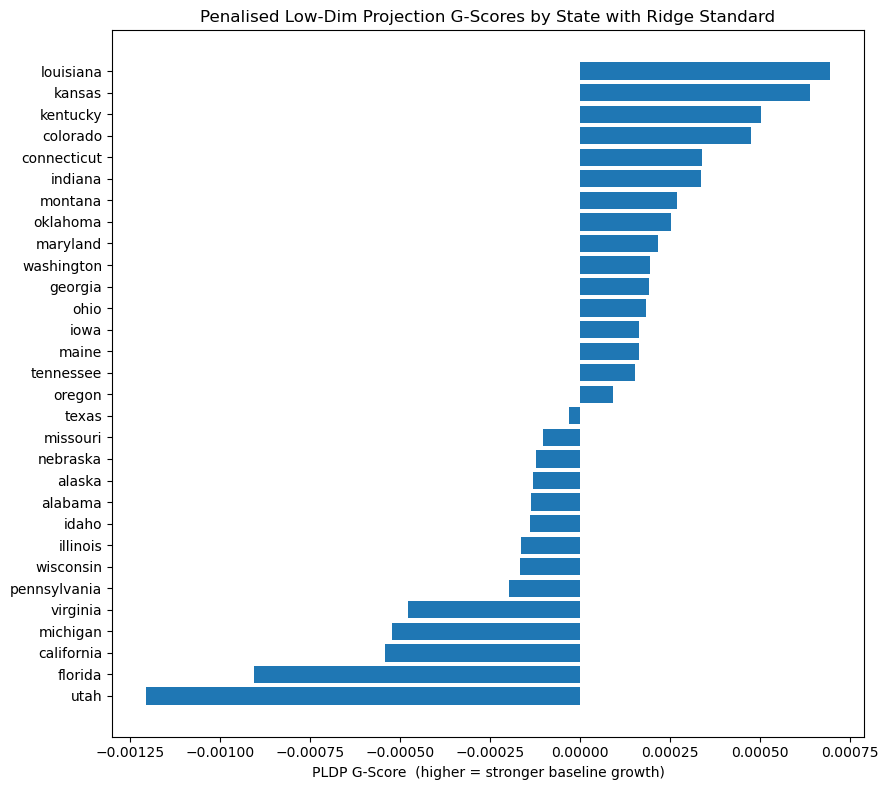

In [110]:
plt.figure(figsize=(9,8))
plt.barh(pldp_state["State"], pldp_state["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("PLDP G‑Score  (higher = stronger baseline growth)")
plt.title("Penalised Low‑Dim Projection G‑Scores by State with Ridge Standard")
plt.tight_layout()
plt.show()

### Using ElasticNet

In [111]:
from sklearn.decomposition import PCA
from sklearn.preprocessing  import StandardScaler
from sklearn.linear_model   import ElasticNetCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np, pandas as pd, matplotlib.pyplot as plt

In [113]:
# ---------------- 1) DATA  ----------------
vars_X = ["assetquality_diff", "profitability_diff", "low_diff"]
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_std = RobustScaler().fit_transform(panel[vars_X].to_numpy(float))
y     = panel["GDP_pre"].to_numpy(float)
states = panel["State"].values

# ---------------- 2) PCA  -----------------
pca = PCA(n_components=0.95, svd_solver="full")
Z   = pca.fit_transform(X_std)          # low‑dim features

# ---------------- 3) ELASTIC‑NET CV  ------
enet = ElasticNetCV(
        l1_ratio = np.linspace(0.05, 0.95, 10),   # 10 points between almost‑ridge and almost‑lasso
        alphas   = np.logspace(-4, 2, 50),        # penalty strengths
        cv       = 5,
        max_iter = 10_000,
        random_state = 42)
enet.fit(Z, y)

print(f"Chosen l1_ratio = {enet.l1_ratio_:.2f}  |  alpha = {enet.alpha_:.4g}")

Chosen l1_ratio = 0.95  |  alpha = 0.0009541


In [114]:
# back‑transform to original variables
beta_pc   = enet.coef_                  # γ in PC space
beta_orig = pca.components_.T @ beta_pc # β in original‑X space

# ---------------- 4) METRICS  -------------
y_hat   = enet.predict(Z)
r2_in   = r2_score(y, y_hat)
rmse_in = np.sqrt(mean_squared_error(y, y_hat))

cv = KFold(5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(enet, Z, y, cv=cv, scoring="r2")

print(f"In‑sample R² : {r2_in: .4f} | RMSE : {rmse_in: .5f}")
print(f"5‑fold CV R² : {cv_r2.mean(): .4f} (±{cv_r2.std(): .4f})")


In‑sample R² :  0.0125 | RMSE :  0.01222
5‑fold CV R² : -0.0033 (± 0.0209)


In [115]:
# ---------------- 5) G‑SCORES -------------
G_scores = X_std @ beta_orig
panel["G_score_enet"] = G_scores

enet_state = (
    panel.groupby("State")["G_score_enet"]
         .mean().reset_index()
         .sort_values("G_score_enet", ascending=False)
         .rename(columns={"G_score_enet": "G_score"})
         .reset_index(drop=True)
)

print("\nElastic‑Net G‑scores  (top 10 states)")
print(enet_state.head(10))


Elastic‑Net G‑scores  (top 10 states)
         State   G_score
0       kansas  0.000277
1    louisiana  0.000198
2      georgia  0.000167
3     kentucky  0.000124
4  connecticut  0.000119
5     colorado  0.000090
6      montana  0.000076
7       oregon  0.000055
8        maine -0.000046
9      indiana -0.000067


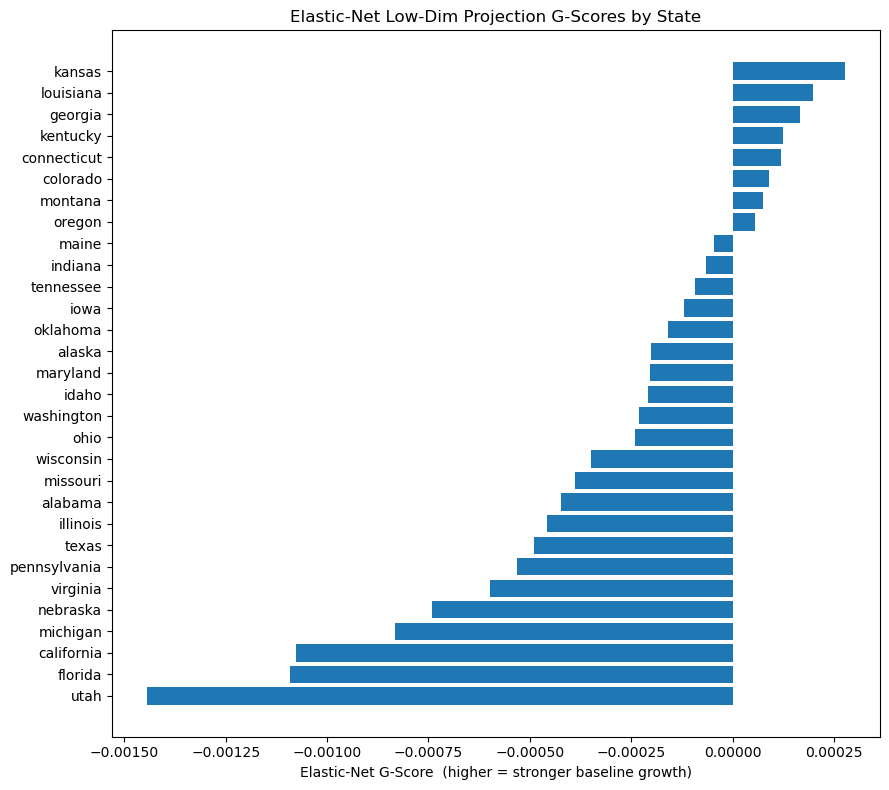

In [116]:
# ---------------- 6) PLOT -----------------
plt.figure(figsize=(9,8))
plt.barh(enet_state["State"], enet_state["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("Elastic‑Net G‑Score  (higher = stronger baseline growth)")
plt.title("Elastic‑Net Low‑Dim Projection G‑Scores by State")
plt.tight_layout(); plt.show()